In [11]:
pip install pandas numpy yfinance

     ---------------------------------------- 0.0/341.8 kB ? eta -:--:--
     ------- -------------------------------- 61.4/341.8 kB ? eta -:--:--
     ------------------- ------------------ 174.1/341.8 kB 3.5 MB/s eta 0:00:01
     -------------------------------------- 341.8/341.8 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
     ---- ----------------------------------- 0.3/2.9 MB 10.2 MB/s eta 0:00:01
     ---------- ----------------------------- 0.8/2.9 MB 8.5 MB/s eta 0:00:01
     ----------------- ---------------------- 1.3/2.9 MB 8.9 MB/s eta 0:00:01
     ------------------------ --------------- 1.8/2.9 MB 8.7 MB/s eta 0:00:01
     ------------------------------ --------- 2.3/2.9 MB 9.0 MB/s eta 0:00:01
     ---------------------------------- ----- 2.5/2.9 MB 8.5 MB/s eta 0:00:01
     ---------------------------------------  2.9/2.9 MB 8.9 MB/s eta 0:00:01
     ---------------------------------------- 2.9/2.9 MB 8.5 MB/s eta 0:00:

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np

In [13]:
#set the stock data we are using
symbol = 'AAPL'  # we are using stock data of Apple Inc.
start_date = '2022-01-01'
end_date = '2023-11-01'

stock_data = yf.download(symbol, start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


In [14]:
print(stock_data.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-01-03  177.830002  182.880005  177.710007  182.009995  179.953903   
2022-01-04  182.630005  182.940002  179.119995  179.699997  177.669998   
2022-01-05  179.610001  180.169998  174.639999  174.919998  172.943985   
2022-01-06  172.699997  175.300003  171.639999  172.000000  170.056992   
2022-01-07  172.889999  174.139999  171.029999  172.169998  170.225052   

               Volume  
Date                   
2022-01-03  104487900  
2022-01-04   99310400  
2022-01-05   94537600  
2022-01-06   96904000  
2022-01-07   86709100  


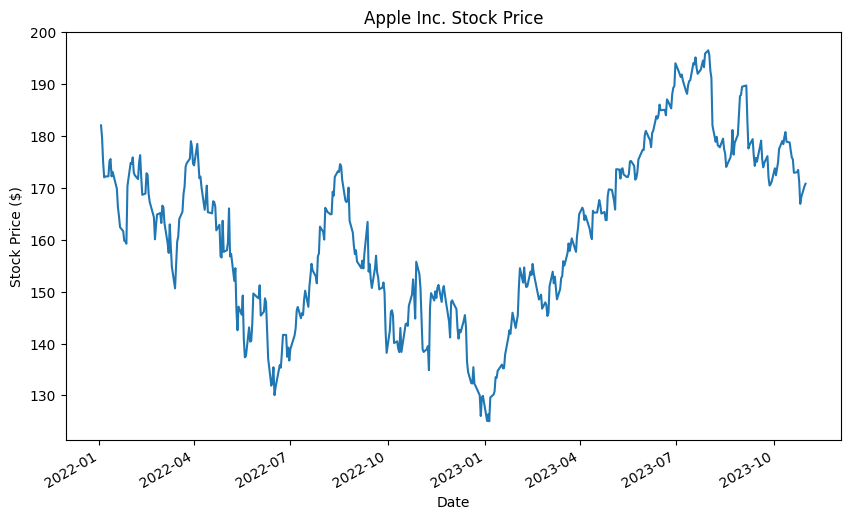

In [18]:
#we visualize the trend of stock price first
import matplotlib.pyplot as plt
stock_data['Close'].plot(figsize=(10, 6), title='Apple Inc. Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.show()

Prepocessing the data

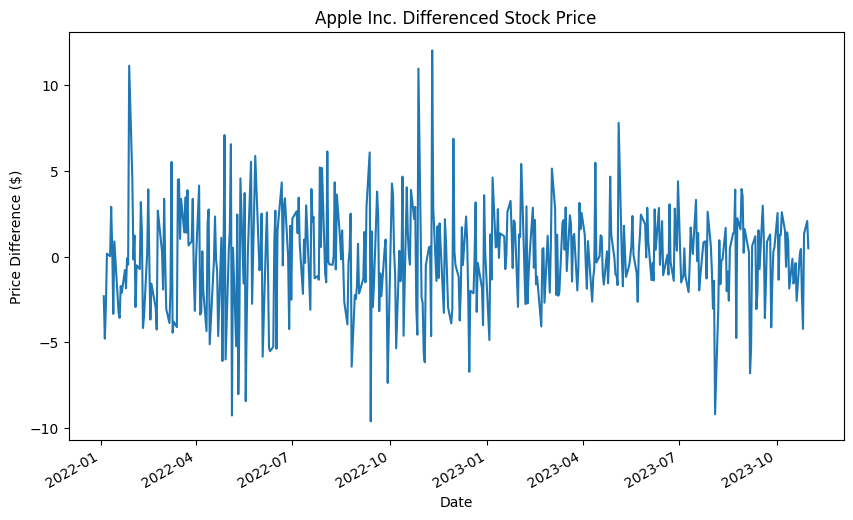

In [19]:
# Take the first differenciation of the closing prices
stock_data['Close_diff'] = stock_data['Close'].diff()

# Drop the NaN values created by differenciation
stock_data.dropna(inplace=True)

# Plot the series
stock_data['Close_diff'].plot(figsize=(10, 6), title='Apple Inc. Differenced Stock Price')
plt.xlabel('Date')
plt.ylabel('Price Difference ($)')
plt.show()


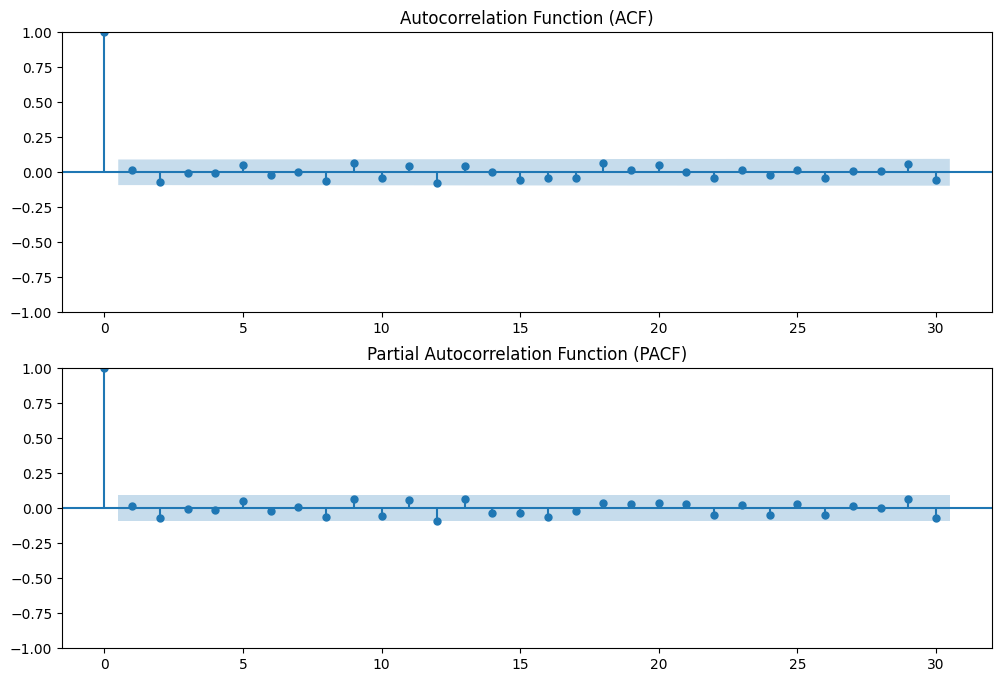

In [21]:
#show the ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF and PACF of the differenced series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(stock_data['Close_diff'], lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(stock_data['Close_diff'], lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

Now normalize and split the data

In [34]:
from sklearn.preprocessing import MinMaxScaler

# Function to create sequences from time series data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Select the differenced prices for prediction
data_diff = stock_data['Close_diff'].values.reshape(-1, 1)

# Normalize the differenced data
scaler_diff = MinMaxScaler()
data_diff_normalized = scaler_diff.fit_transform(data_diff)

# Split the differenced data into training and testing sets
train_size_diff = int(len(data_diff_normalized) * 0.8)
train_data_diff, test_data_diff = data_diff_normalized[:train_size_diff], data_diff_normalized[train_size_diff:]

# Convert the differenced data into sequences for the RNN
seq_length = 40
X_train_diff = create_sequences(train_data_diff, seq_length)
X_test_diff = create_sequences(test_data_diff, seq_length)

# Create the target variable for differenced data
y_train_diff = train_data_diff[seq_length:]
y_test_diff = test_data_diff[seq_length:]


In [25]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

In [35]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, activation='tanh', input_shape=(X_train_diff.shape[1], 1)))
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [36]:
# Train the model
model.fit(X_train_diff, y_train_diff, epochs=10, batch_size=32)

# Evaluate the model on the test set
loss = model.evaluate(X_test_diff, y_test_diff)
print(f'Mean Squared Error on Test Set: {loss}')

# Make predictions on the test set
y_pred_diff = model.predict(X_test_diff)

# Inverse transform the predictions and the actual values
y_pred = scaler_diff.inverse_transform(y_pred_diff)
y_actual = scaler_diff.inverse_transform(y_test_diff)

Epoch 1/10
11/11 [==============================] - 1s 30ms/step - loss: 0.0723
Epoch 2/10
11/11 [==============================] - 0s 28ms/step - loss: 0.0297
Epoch 3/10
11/11 [==============================] - 0s 34ms/step - loss: 0.0234
Epoch 4/10
11/11 [==============================] - 0s 27ms/step - loss: 0.0224
Epoch 5/10
11/11 [==============================] - 0s 34ms/step - loss: 0.0227
Epoch 6/10
11/11 [==============================] - 0s 27ms/step - loss: 0.0212
Epoch 7/10
11/11 [==============================] - 0s 27ms/step - loss: 0.0213
Epoch 8/10
11/11 [==============================] - 0s 28ms/step - loss: 0.0212
Epoch 9/10
11/11 [==============================] - 0s 29ms/step - loss: 0.0212
Epoch 10/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0131
Mean Squared Error on Test Set: 0.013129050843417645
2/2 [==============================] - 0s 17ms/step


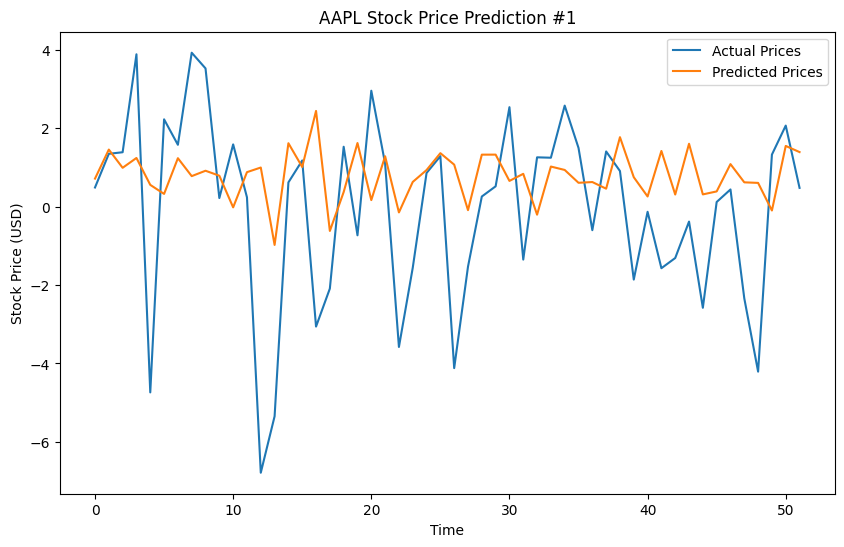

In [37]:
# Plot the predictions and actual values
plt.figure(figsize=(10, 6))
plt.plot(y_actual, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.title(f'{symbol} Stock Price Prediction #1')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

Epoch 1/20
11/11 [==============================] - 3s 142ms/step - loss: 0.6601 - val_loss: 0.0655
Epoch 2/20
11/11 [==============================] - 1s 116ms/step - loss: 0.4080 - val_loss: 0.0203
Epoch 3/20
11/11 [==============================] - 1s 109ms/step - loss: 0.3891 - val_loss: 0.0287
Epoch 4/20
11/11 [==============================] - 1s 118ms/step - loss: 0.2953 - val_loss: 0.0155
Epoch 5/20
11/11 [==============================] - 1s 117ms/step - loss: 0.3288 - val_loss: 0.0412
Epoch 6/20
11/11 [==============================] - 1s 119ms/step - loss: 0.3402 - val_loss: 0.0918
Epoch 7/20
11/11 [==============================] - 1s 115ms/step - loss: 0.3069 - val_loss: 0.0325
Epoch 8/20
11/11 [==============================] - 1s 118ms/step - loss: 0.2751 - val_loss: 0.0372
Epoch 9/20
11/11 [==============================] - 1s 118ms/step - loss: 0.2528 - val_loss: 0.0175
Epoch 10/20
11/11 [==============================] - 1s 122ms/step - loss: 0.1993 - val_loss: 0.0220

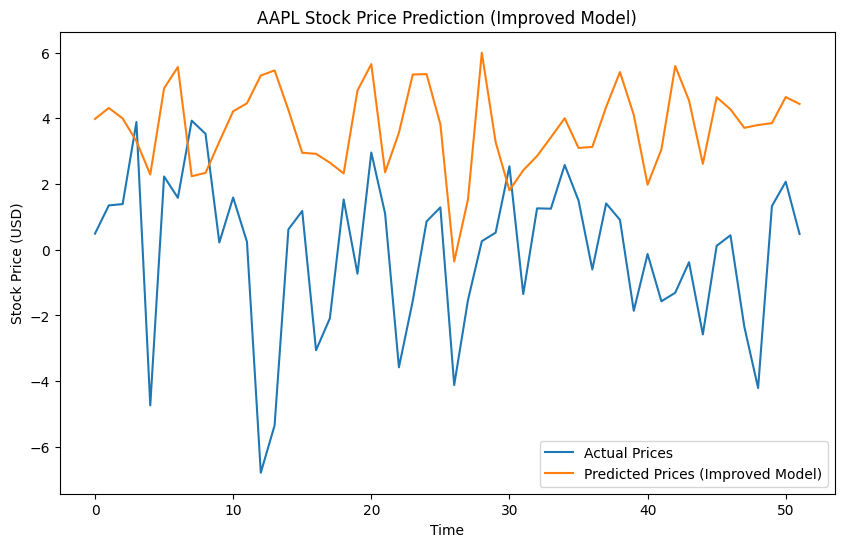

In [41]:
# Build an improved RNN model
model2= Sequential()
model2.add(SimpleRNN(units=100, activation='tanh', input_shape=(X_train_diff.shape[1], 1), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(SimpleRNN(units=50, activation='tanh', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(SimpleRNN(units=25, activation='tanh'))
model2.add(Dropout(0.2))
model2.add(Dense(units=1, activation='linear'))

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

history = model2.fit(X_train_diff, y_train_diff, epochs=20, batch_size=32, validation_data=(X_test_diff, y_test_diff))


# Evaluate the model on the test set
loss = model2.evaluate(X_test_diff, y_test_diff)
print(f'Mean Squared Error on Test Set: {loss}')


# Make predictions on the test set
y_pred_diff_improved = model2.predict(X_test_diff)

# Inverse transform the predictions and the actual values
y_pred_improved = scaler_diff.inverse_transform(y_pred_diff_improved)
y_actual_improved = scaler_diff.inverse_transform(y_test_diff)

# Plot the predictions and actual values
plt.figure(figsize=(10, 6))
plt.plot(y_actual_improved, label='Actual Prices')
plt.plot(y_pred_improved, label='Predicted Prices (Improved Model)')
plt.title(f'{symbol} Stock Price Prediction (Improved Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


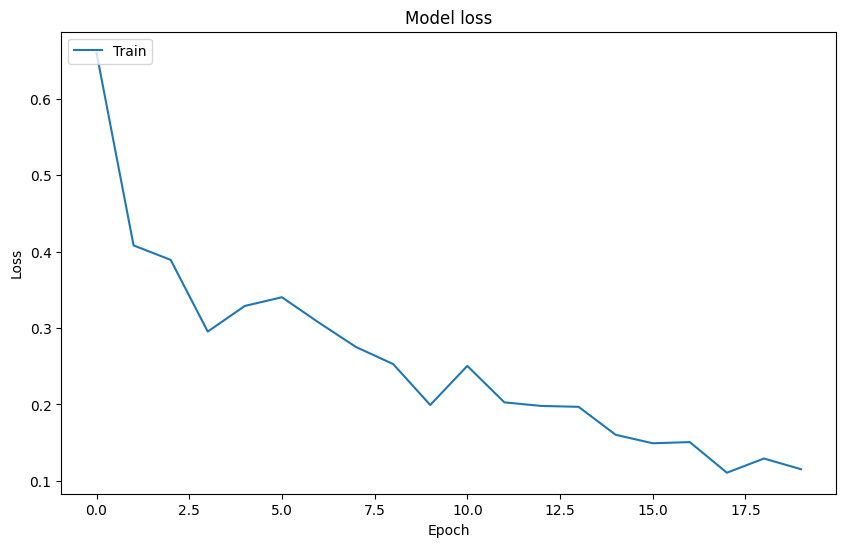

Mean Squared Error: 21.170802461992984
Mean Absolute Error: 3.952861595039184
Root Mean Squared Error: 4.601174030830934
R-squared (R2) Score: -2.8298532195602633
Percentage Error: 472.8433130798149%
Median Absolute Error: 3.6831949949264526


In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

def plot_training_curve(history):
    plt.figure(figsize=(10, 6))

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()

plot_training_curve(history)
# Print regression metrics
mse = mean_squared_error(y_actual_improved, y_pred_improved)
mae = mean_absolute_error(y_actual_improved, y_pred_improved)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
#rmse
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')
#R2 score
r2 = r2_score(y_actual_improved, y_pred_improved)
print(f'R-squared (R2) Score: {r2}')
#percentage error
percentage_error = np.mean(np.abs((y_actual_improved - y_pred_improved) / y_actual_improved)) * 100
print(f'Percentage Error: {percentage_error}%')
#median absolute error
medae = median_absolute_error(y_actual_improved, y_pred_improved)
print(f'Median Absolute Error: {medae}')



Epoch 1/50
6/6 [==============================] - 4s 300ms/step - loss: 1.2094 - val_loss: 0.0382
Epoch 2/50
6/6 [==============================] - 1s 235ms/step - loss: 0.8079 - val_loss: 0.0747
Epoch 3/50
6/6 [==============================] - 1s 205ms/step - loss: 0.6804 - val_loss: 0.1220
Epoch 4/50
6/6 [==============================] - 1s 212ms/step - loss: 0.6043 - val_loss: 0.0547
Epoch 5/50
6/6 [==============================] - 1s 236ms/step - loss: 0.4941 - val_loss: 0.0333
Epoch 6/50
6/6 [==============================] - 1s 220ms/step - loss: 0.4883 - val_loss: 0.0313
Epoch 7/50
6/6 [==============================] - 1s 241ms/step - loss: 0.5048 - val_loss: 0.0373
Epoch 8/50
6/6 [==============================] - 1s 222ms/step - loss: 0.4370 - val_loss: 0.0679
Epoch 9/50
6/6 [==============================] - 1s 229ms/step - loss: 0.4454 - val_loss: 0.0306
Epoch 10/50
6/6 [==============================] - 1s 222ms/step - loss: 0.5037 - val_loss: 0.1544
Epoch 11/50
6/6 [==

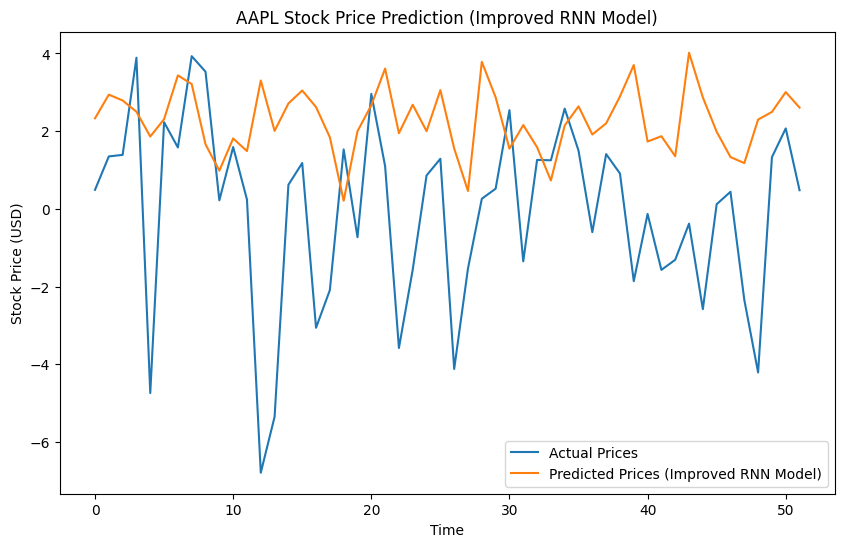

In [47]:
from tensorflow.keras.layers import Bidirectional

# Build an improved RNN model
improved_model_rnn = Sequential()
improved_model_rnn.add(Bidirectional(SimpleRNN(units=100, activation='tanh', input_shape=(X_train_diff.shape[1], 1), return_sequences=True)))
improved_model_rnn.add(Dropout(0.3))
improved_model_rnn.add(Bidirectional(SimpleRNN(units=50, activation='tanh', return_sequences=True)))
improved_model_rnn.add(Dropout(0.3))
improved_model_rnn.add(Bidirectional(SimpleRNN(units=25, activation='tanh')))
improved_model_rnn.add(Dropout(0.3))
improved_model_rnn.add(Dense(units=1, activation='linear'))

# Compile the model with a lower learning rate
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
improved_model_rnn.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Train the model with a longer duration
history_rnn = improved_model_rnn.fit(X_train_diff, y_train_diff, epochs=50, batch_size=64, validation_data=(X_test_diff, y_test_diff))

# Evaluate the RNN model
loss_rnn = improved_model_rnn.evaluate(X_test_diff, y_test_diff)
print(f'Mean Squared Error on Test Set (RNN): {loss_rnn}')

# Make predictions on the test set
y_pred_diff_rnn = improved_model_rnn.predict(X_test_diff)

# Inverse transform the predictions
y_pred_rnn = scaler_diff.inverse_transform(y_pred_diff_rnn)



# Plot the predictions and actual values
plt.figure(figsize=(10, 6))
plt.plot(y_actual_improved, label='Actual Prices')
plt.plot(y_pred_rnn, label='Predicted Prices (Improved RNN Model)')
plt.title(f'{symbol} Stock Price Prediction (Improved RNN Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


Percentage Error (RNN): 265.01631318990565%


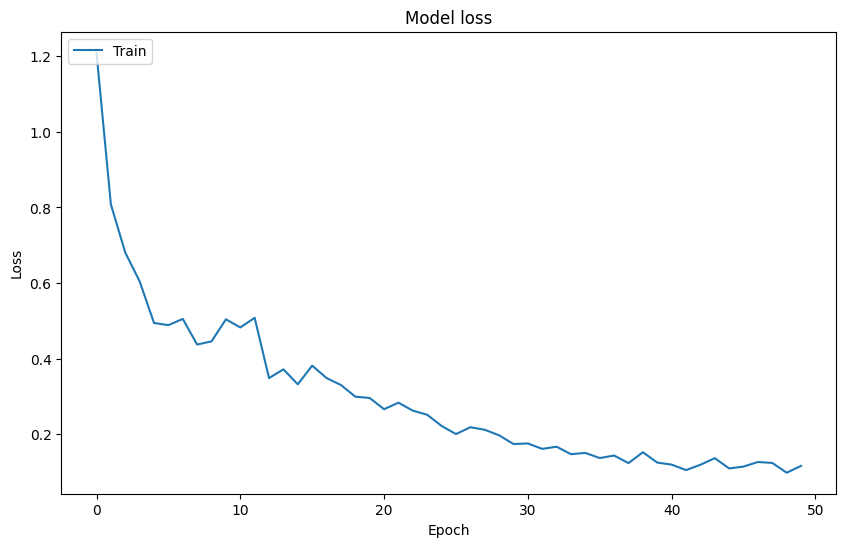

In [48]:
# Calculate percentage error for the RNN model
percentage_error_rnn = np.mean(np.abs((y_actual_improved - y_pred_rnn) / y_actual_improved)) * 100
print(f'Percentage Error (RNN): {percentage_error_rnn}%')

# Plot the training curve
plot_training_curve(history_rnn)

Now trying LSTM

In [51]:
from tensorflow.keras.layers import LSTM

# Build an LSTM model
improved_model_lstm = Sequential()
improved_model_lstm.add(LSTM(units=100, activation='tanh', input_shape=(X_train_diff.shape[1], 1), return_sequences=True))
improved_model_lstm.add(Dropout(0.2))
improved_model_lstm.add(LSTM(units=50, activation='tanh', return_sequences=True))
improved_model_lstm.add(Dropout(0.2))
improved_model_lstm.add(LSTM(units=25, activation='tanh'))
improved_model_lstm.add(Dropout(0.2))
improved_model_lstm.add(Dense(units=1, activation='linear'))

# Compile and train the LSTM model
improved_model_lstm.compile(optimizer='adam', loss='mean_squared_error')
history_lstm = improved_model_lstm.fit(X_train_diff, y_train_diff, epochs=20, batch_size=32, validation_data=(X_test_diff, y_test_diff))

# Evaluate the LSTM model
loss_lstm = improved_model_lstm.evaluate(X_test_diff, y_test_diff)
print(f'Mean Squared Error on Test Set (LSTM): {loss_lstm}')

# Make predictions on the test set
y_pred_diff_lstm = improved_model_lstm.predict(X_test_diff)

# Inverse transform the predictions
y_pred_lstm = scaler_diff.inverse_transform(y_pred_diff_lstm)

# Calculate percentage error for the LSTM model
percentage_error_lstm = np.mean(np.abs((y_actual_improved - y_pred_lstm) / y_actual_improved)) * 100
print(f'Percentage Error (LSTM): {percentage_error_lstm}%')


Epoch 1/20
11/11 [==============================] - 6s 95ms/step - loss: 0.0736 - val_loss: 0.0209
Epoch 2/20
11/11 [==============================] - 0s 22ms/step - loss: 0.0323 - val_loss: 0.0146
Epoch 3/20
11/11 [==============================] - 0s 20ms/step - loss: 0.0267 - val_loss: 0.0135
Epoch 4/20
11/11 [==============================] - 0s 20ms/step - loss: 0.0236 - val_loss: 0.0130
Epoch 5/20
11/11 [==============================] - 0s 21ms/step - loss: 0.0241 - val_loss: 0.0129
Epoch 6/20
11/11 [==============================] - 0s 22ms/step - loss: 0.0255 - val_loss: 0.0132
Epoch 7/20
11/11 [==============================] - 0s 20ms/step - loss: 0.0238 - val_loss: 0.0129
Epoch 8/20
11/11 [==============================] - 0s 20ms/step - loss: 0.0233 - val_loss: 0.0134
Epoch 9/20
11/11 [==============================] - 0s 20ms/step - loss: 0.0228 - val_loss: 0.0131
Epoch 10/20
11/11 [==============================] - 0s 21ms/step - loss: 0.0222 - val_loss: 0.0133
Epoch 11/

In [59]:
# Build an advanced LSTM model
advanced_model_lstm = Sequential()
advanced_model_lstm.add(LSTM(units=256, activation='tanh', input_shape=(X_train_diff.shape[1], 1), return_sequences=True))
advanced_model_lstm.add(Dropout(0.3))
advanced_model_lstm.add(LSTM(units=128, activation='tanh', return_sequences=True))
advanced_model_lstm.add(Dropout(0.3))
advanced_model_lstm.add(LSTM(units=64, activation='tanh'))
advanced_model_lstm.add(Dropout(0.3))
advanced_model_lstm.add(Dense(units=1, activation='linear'))

# Compile and train the advanced LSTM model
optimizer = Adam(learning_rate=0.0005, clipvalue=0.5)
advanced_model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')
history_lstm_advanced = advanced_model_lstm.fit(X_train_diff, y_train_diff, epochs=50, batch_size=64, validation_data=(X_test_diff, y_test_diff), callbacks=[early_stopping])

# Evaluate the advanced LSTM model
loss_lstm_advanced = advanced_model_lstm.evaluate(X_test_diff, y_test_diff)
print(f'Mean Squared Error on Test Set (Advanced LSTM): {loss_lstm_advanced}')

# Make predictions on the test set
y_pred_diff_lstm_advanced = advanced_model_lstm.predict(X_test_diff)

# Inverse transform the predictions
y_pred_lstm_advanced = scaler_diff.inverse_transform(y_pred_diff_lstm_advanced)


# Calculate percentage error for the advanced LSTM model
percentage_error_lstm_advanced = np.mean(np.abs((y_actual_improved - y_pred_lstm_advanced) / y_actual_improved)) * 100
print(f'Percentage Error (Advanced LSTM): {percentage_error_lstm_advanced}%')


Epoch 1/50
6/6 [==============================] - 3s 173ms/step - loss: 0.1025 - val_loss: 0.0242
Epoch 2/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0366 - val_loss: 0.0309
Epoch 3/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0314 - val_loss: 0.0134
Epoch 4/50
6/6 [==============================] - 0s 28ms/step - loss: 0.0294 - val_loss: 0.0132
Epoch 5/50
6/6 [==============================] - 0s 26ms/step - loss: 0.0251 - val_loss: 0.0168
Epoch 6/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0256 - val_loss: 0.0131
Epoch 7/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0240 - val_loss: 0.0133
Epoch 8/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0245 - val_loss: 0.0131
Epoch 9/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0233 - val_loss: 0.0133
Epoch 10/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0220 - val_loss: 0.0131
Epoch 11/50
6/6 [===========

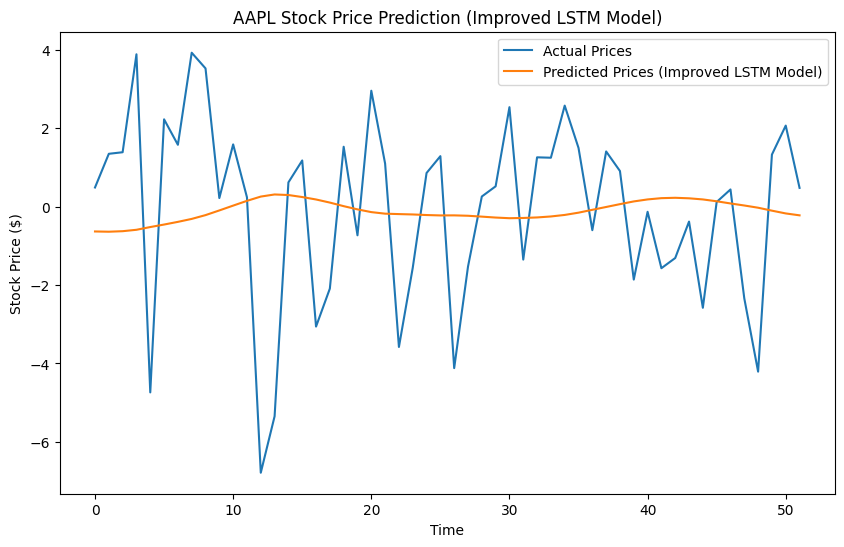

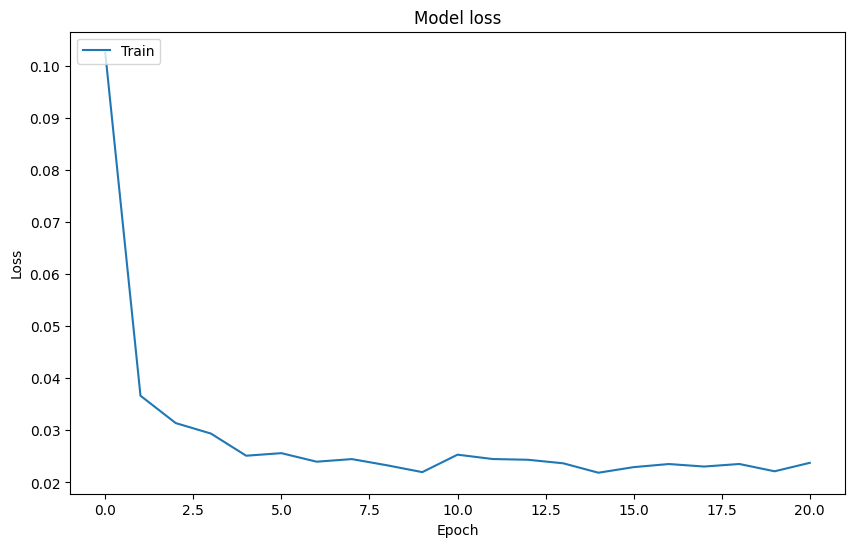

In [60]:
# Plot the predictions and actual values
plt.figure(figsize=(10, 6))
plt.plot(y_actual_improved, label='Actual Prices')
plt.plot(y_pred_lstm_advanced, label='Predicted Prices (Improved LSTM Model)')
plt.title(f'{symbol} Stock Price Prediction (Improved LSTM Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.show()

# Plot the training curve
plot_training_curve(history_lstm_advanced)

Epoch 1/50
6/6 [==============================] - 2s 127ms/step - loss: 0.1851 - val_loss: 0.1384
Epoch 2/50
6/6 [==============================] - 0s 22ms/step - loss: 0.1348 - val_loss: 0.0944
Epoch 3/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0923 - val_loss: 0.0601
Epoch 4/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0632 - val_loss: 0.0357
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0402 - val_loss: 0.0208
Epoch 6/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0276 - val_loss: 0.0142
Epoch 7/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0237 - val_loss: 0.0132
Epoch 8/50
6/6 [==============================] - 0s 19ms/step - loss: 0.0241 - val_loss: 0.0142
Epoch 9/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0263 - val_loss: 0.0141
Epoch 10/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0234 - val_loss: 0.0134
Epoch 11/50
6/6 [===========

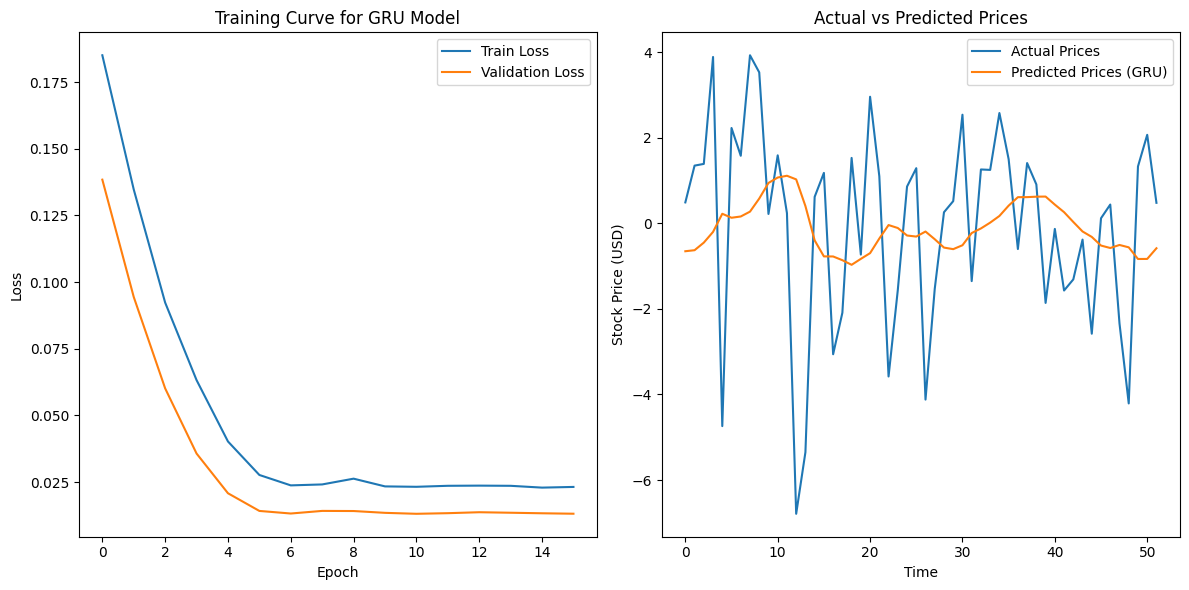

In [62]:
from tensorflow.keras.layers import GRU

# Build a GRU model
gru_model = Sequential()
gru_model.add(GRU(units=128, activation='tanh', input_shape=(X_train_diff.shape[1], 1), return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=64, activation='tanh'))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=1, activation='linear'))

# Compile and train the GRU model
optimizer = Adam(learning_rate=0.0001, clipvalue=0.5)
gru_model.compile(optimizer=optimizer, loss='mean_squared_error')
history_gru = gru_model.fit(X_train_diff, y_train_diff, epochs=50, batch_size=64, validation_data=(X_test_diff, y_test_diff), callbacks=[early_stopping])

# Evaluate the GRU model
loss_gru = gru_model.evaluate(X_test_diff, y_test_diff)
print(f'Mean Squared Error on Test Set (GRU): {loss_gru}')

# Plot the training curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Training Curve for GRU Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Make predictions on the test set
y_pred_diff_gru = gru_model.predict(X_test_diff)

# Inverse transform the predictions
y_pred_gru = scaler_diff.inverse_transform(y_pred_diff_gru)

# Calculate percentage error for the GRU model
percentage_error_gru = np.mean(np.abs((y_actual_improved - y_pred_gru) / y_actual_improved)) * 100
print(f'Percentage Error (GRU): {percentage_error_gru}%')

# Plot actual vs predicted values
plt.subplot(1, 2, 2)
plt.plot(y_actual_improved, label='Actual Prices')
plt.plot(y_pred_gru, label='Predicted Prices (GRU)')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()

plt.tight_layout()
plt.show()


Try on data that has not been differentiated
Since the model I built are pretty simple, using residuals of prices might not works well.

In [79]:
# Extract the 'Close' prices
prices = stock_data['Close'].values.reshape(-1, 1)

# Normalize the prices
scaler = MinMaxScaler(feature_range=(0, 1))
prices_normalized = scaler.fit_transform(prices)

# Split the data into training and testing sets
train_size = int(len(prices_normalized) * 0.8)
train_data, test_data = prices_normalized[:train_size], prices_normalized[train_size:]

# Function to create sequences for time series data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Define the sequence length
sequence_length = 10  # You can adjust this based on your preference

# Create sequences for training and testing
X_train = create_sequences(train_data, sequence_length)
y_train = train_data[sequence_length:]
X_test = create_sequences(test_data, sequence_length)
y_test = test_data[sequence_length:]

Epoch 1/50
6/6 [==============================] - 4s 213ms/step - loss: 0.0663 - val_loss: 0.0566
Epoch 2/50
6/6 [==============================] - 0s 48ms/step - loss: 0.0154 - val_loss: 0.0468
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0170 - val_loss: 0.0133
Epoch 4/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 5/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0090 - val_loss: 0.0083
Epoch 6/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 7/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0072 - val_loss: 0.0046
Epoch 8/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0070 - val_loss: 0.0047
Epoch 9/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0065 - val_loss: 0.0042
Epoch 10/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 11/50
6/6 [===========

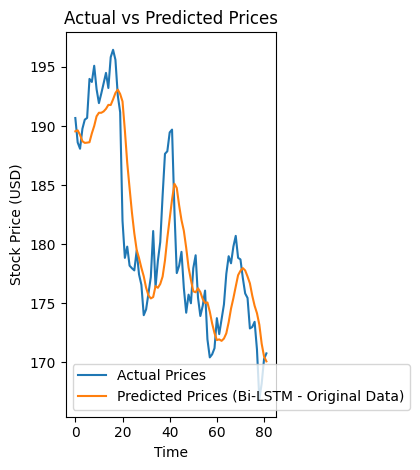

In [81]:
# Build a Bi-LSTM model for the original data
bi_lstm_model_original = Sequential()
bi_lstm_model_original.add(Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True), input_shape=(sequence_length, 1)))
bi_lstm_model_original.add(Dropout(0.2))
bi_lstm_model_original.add(Bidirectional(LSTM(units=64, activation='tanh')))
bi_lstm_model_original.add(Dropout(0.2))
bi_lstm_model_original.add(Dense(units=1, activation='linear'))

# Compile and train the Bi-LSTM model
optimizer = Adam(learning_rate=0.001, clipvalue=0.5)
bi_lstm_model_original.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_bi_lstm_original = bi_lstm_model_original.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])


# Make predictions on the test set
y_pred_bi_lstm_original = bi_lstm_model_original.predict(X_test)

# Inverse transform the predictions
y_pred_original = scaler.inverse_transform(y_pred_bi_lstm_original.reshape(-1, 1))

# Inverse transform the actual values
y_actual_original = scaler.inverse_transform(y_test)

# Plot actual vs predicted values
plt.subplot(1, 2, 2)
plt.plot(y_actual_original, label='Actual Prices')
plt.plot(y_pred_original, label='Predicted Prices (Bi-LSTM - Original Data)')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()

plt.tight_layout()
plt.show()

3/3 [==============================] - 0s 17ms/step - loss: 0.0030
Mean Squared Error on Test Set (Bi-LSTM - Original Data): 0.0030262144282460213
Mean Squared Error (Bi-LSTM - Original Data): 15.44049098149294
Percentage Error (Bi-LSTM - Original Data): 1.7446497786165982%


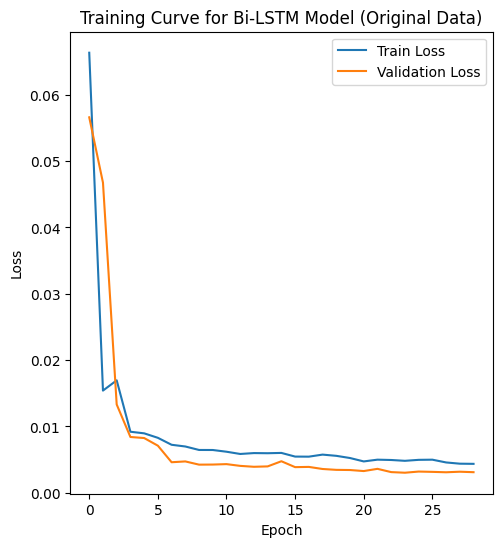

In [82]:
# Evaluate the Bi-LSTM model on the original data
loss_bi_lstm_original = bi_lstm_model_original.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set (Bi-LSTM - Original Data): {loss_bi_lstm_original}')

# Calculate Mean Squared Error (MSE) for the original data
mse_bi_lstm_original = mean_squared_error(y_actual_original, y_pred_original)
print(f'Mean Squared Error (Bi-LSTM - Original Data): {mse_bi_lstm_original}')

# Calculate Percentage Error for the original data
percentage_error_bi_lstm_original = np.mean(np.abs((y_actual_original - y_pred_original) / y_actual_original)) * 100
print(f'Percentage Error (Bi-LSTM - Original Data): {percentage_error_bi_lstm_original}%')
# Plot the training curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_bi_lstm_original.history['loss'], label='Train Loss')
plt.plot(history_bi_lstm_original.history['val_loss'], label='Validation Loss')
plt.title('Training Curve for Bi-LSTM Model (Original Data)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()